In [23]:
import os
from typing import Optional
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score

import torch
import torchvision
from torch import nn

from PIL import Image
from torch.utils.data import Dataset, DataLoader

from torchmetrics import Accuracy, F1Score

import pytorch_lightning as pl
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter, GaussianBlur, RandomGrayscale, \
    Compose, Resize, RandomApply, ToTensor, Normalize

In [2]:
class AgeDataset(Dataset):
    def __init__(self, data, transforms, path='../data/train'):
        self.data = data
        self.transforms = transforms
        self.path = path

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_id = row['ImageID']
        target = row['target']
        the_image = Image.open(os.path.join(self.path, image_id + '.jpg'))
        transformed_image = self.transforms(the_image)
        return transformed_image, target

In [3]:
class AgePredictionData(pl.LightningDataModule):
    def __init__(self, train_data, val_data, train_batch=64, train_path='../data/train', val_path='../data/val'):
        super().__init__()
        self.train_path = train_path
        self.val_path = val_path
        self.train_data = train_data
        self.val_data = val_data
        self.augmentations = [
            RandomHorizontalFlip(0.5),
            RandomRotation(30),
            ColorJitter(brightness=.5, hue=.3),
            GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
            RandomGrayscale()
        ]
        self.train_transforms = Compose([
            Resize((256, 256)),
            RandomApply(self.augmentations, p=0.6),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.transforms = Compose([Resize((256, 256)), ToTensor(),
                                   Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        self.train_batch = train_batch
        self.val_batch = train_batch * 4

    def setup(self, stage: Optional[str] = None):
        if stage == 'fit' or stage is None:
            print('inside stage fit')
            self.train_data = AgeDataset(self.train_data, self.train_transforms, self.train_path)
            self.val_data = AgeDataset(self.val_data, self.transforms, self.val_path)

        if stage == 'predict':
            print("inside stage predict")
            self.val_data = AgeDataset(self.val_data, self.transforms, self.val_path)

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.train_batch, shuffle=True, pin_memory=True,
                          num_workers=16)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.val_batch, shuffle=False, pin_memory=True,
                          num_workers=16)

    def predict_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.val_batch, shuffle=False, pin_memory=True, num_workers=16)

In [4]:
class AgePredictResnet(nn.Module):
    def __init__(self, num_targets=10):
        super().__init__()

        self.model = torchvision.models.resnet101(pretrained=True)
        self.model.fc = nn.Linear(2048, num_targets)

    def forward(self, x):
        out = self.model(x)
        return out

In [70]:
class AgePrediction(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = AgePredictResnet()
        self.criterion = nn.CrossEntropyLoss()
        self.acc = Accuracy()
        self.f1 = F1Score()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, image, transforms):
        print("inside forward")
        image = transforms(image)
        image = torch.unsqueeze(image, 0)
        print('the image dimensions are :', image.shape)
        self.model.eval()
        logits = self.model(image)
        print("the logits are:", logits)
#         pred_probabilities = self.softmax(logits)
#         print("The probabilities : ", pred_probabilities)
#         prediction = torch.argmax(pred_probabilities, dim=1)
        prediction = torch.argmax(logits, dim=1)
        return prediction

    def training_step(self, input_batch, batch_idx):
        image_tensors = input_batch[0]
        targets = input_batch[1]

        logits = self.model(image_tensors)
        loss = self.criterion(logits, targets)

        predictions = torch.argmax(logits, dim=1)
        the_acc = self.acc(predictions, targets)

        self.log("train-loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train-acc", the_acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, input_batch, batch_idx):
        image_tensors = input_batch[0]
        targets = input_batch[1]

        logits = self.model(image_tensors)

        loss = self.criterion(logits, targets)
        predictions = torch.argmax(logits, dim=1)
        the_acc = self.acc(predictions, targets)

        self.log("val-loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val-acc", the_acc, on_step=False, on_epoch=True, prog_bar=True)

    def predict_step(self, input_batch, batch_idx):
        print("inside predict_step")
        image_tensors = input_batch[0]
        targets = input_batch[1]

        logits = self.model(image_tensors)

        predictions = torch.argmax(logits, dim=1)
        return predictions.cpu().detach().numpy()

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.00002)

    def load_previous_trained_model(self, model_path):
        self.model.load_state_dict(torch.load(model_path))

In [62]:
def train_model(train_module, data_module):
    checkpoint_callback = ModelCheckpoint(filename='{epoch}-{val-acc:.3f}', save_top_k=1, monitor='val-acc'
                                          , mode='max')
    early_stopping = EarlyStopping(monitor="val-acc", patience=20, verbose=False, mode="max")
    wandb_logger = WandbLogger(project="Age_Prediction", save_dir='lightning_logs',
                               name="resnet101_64_low_lr_batch_normalized_updated_augmented_adamw")

    trainer = pl.Trainer(accelerator='gpu', fast_dev_run=False, max_epochs=100,
                         callbacks=[checkpoint_callback, early_stopping], logger=wandb_logger, precision=16,
                         log_every_n_steps=25)
    trainer.fit(train_module, data_module)


def only_validate_model(train_module, data_module, model_path):
    wandb_logger = WandbLogger(project="Age_Prediction", save_dir='lightning_logs',
                               name="resnet101_64_testing")
    trainer = pl.Trainer(accelerator='gpu', fast_dev_run=False, precision=16, logger=wandb_logger)
    data_module.setup()
    trainer.validate(train_module, data_module, ckpt_path=model_path)
    # trainer.validate(train_module, data_module)

def get_predictions(train_module, data_module, model_path):
    trainer = pl.Trainer(accelerator='gpu', fast_dev_run=False, precision=16)
    data_module.setup(stage='predict')
    all_preds = trainer.predict(train_module, data_module, ckpt_path=model_path)
    return all_preds

In [7]:
def train_data(the_path):
    train = pd.read_csv(the_path)
    train = train.sample(frac=1).reset_index(drop=True)
    return train


def val_data(the_path):
    val = pd.read_csv(the_path)
    return val

In [40]:
train_module = AgePrediction()
path = '../data'
checkpoint_path = '../lightning_logs/resnet101_64_low_lr_batch_normalized_updated_augmented_adamw/4fg9axib' \
                  '/checkpoints/epoch=22-val-acc=0.828.ckpt'
train_images = train_data(os.path.join(path, 'train_new.csv'))
val_images = val_data(os.path.join(path, 'val_new.csv'))
data_module = AgePredictionData(train_images, val_images, 64)

In [41]:
data_module.setup()

inside stage fit


In [55]:
sample_batch = next(iter(data_module.train_dataloader()))

In [60]:
sample_batch[0].shape

torch.Size([64, 3, 256, 256])

In [47]:
sample[0].shape

torch.Size([3, 256, 256])

In [9]:
data_module.val_data

ImageID     age  target
0      444vl   40-50       4
1      4eg4u   80-90       8
2      8pk8y   40-50       4
3      qow33  90-100       9
4      7ittd   20-30       2
...      ...     ...     ...
1995   0od5t    0-10       0
1996   do352   80-90       8
1997   m58bc  90-100       9
1998   6xxax   50-60       5
1999   vd7h5   40-50       4

[2000 rows x 3 columns]

In [10]:
len(data_module.val_data)

2000

In [11]:
trainer = pl.Trainer(accelerator='gpu', fast_dev_run=False, precision=16)

Using 16bit native Automatic Mixed Precision (AMP)
/home/antpc/anaconda3/envs/personal_projects/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:93: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
all_preds = trainer.predict(train_module, data_module, ckpt_path=checkpoint_path)

Restoring states from the checkpoint path at ../lightning_logs/resnet101_64_low_lr_batch_normalized_updated_augmented_adamw/4fg9axib/checkpoints/epoch=22-val-acc=0.828.ckpt


inside stage predict


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ../lightning_logs/resnet101_64_low_lr_batch_normalized_updated_augmented_adamw/4fg9axib/checkpoints/epoch=22-val-acc=0.828.ckpt


Predicting: 0it [00:00, ?it/s]

inside predict_step
inside predict_step
inside predict_step
inside predict_step
inside predict_step
inside predict_step
inside predict_step
inside predict_step


In [29]:
train_module.state_dict()

OrderedDict([('model.model.conv1.weight',
              tensor([[[[ 2.0534e-02, -3.8869e-03, -1.7681e-02,  ..., -1.4499e-02,
                         -7.4252e-04,  1.0165e-02],
                        [-3.6846e-03,  3.8268e-03, -1.5227e-02,  ..., -8.3637e-02,
                         -7.4032e-02, -3.9792e-02],
                        [ 3.9331e-03,  2.7408e-02,  5.1588e-02,  ...,  3.4260e-02,
                          1.4695e-02,  2.8738e-02],
                        ...,
                        [-3.5679e-02, -1.2914e-01, -3.0282e-01,  ..., -3.7310e-01,
                         -1.2909e-01,  4.3665e-02],
                        [ 1.5834e-02,  2.4005e-02,  7.1713e-03,  ..., -1.6352e-01,
                         -1.8141e-01, -9.6457e-02],
                        [-3.0174e-02, -1.0852e-02,  5.0578e-02,  ...,  1.6479e-01,
                          1.0504e-01, -1.1844e-02]],
              
                       [[ 8.9293e-03, -5.5073e-03, -1.1783e-02,  ..., -1.3125e-02,
                    

In [16]:
preds = np.concatenate(all_preds, axis=0)

In [17]:
preds

array([2, 8, 4, ..., 9, 5, 3])

In [19]:
val_images.shape

(2000, 3)

In [21]:
val_images['new_predictions'] = preds

In [22]:
val_images

ImageID     age  target  new_predictions
0      444vl   40-50       4                2
1      4eg4u   80-90       8                8
2      8pk8y   40-50       4                4
3      qow33  90-100       9                9
4      7ittd   20-30       2                2
...      ...     ...     ...              ...
1995   0od5t    0-10       0                0
1996   do352   80-90       8                8
1997   m58bc  90-100       9                9
1998   6xxax   50-60       5                5
1999   vd7h5   40-50       4                3

[2000 rows x 4 columns]

In [27]:
val_images[val_images.ImageID == '1ci33']

ImageID    age  target  new_predictions
1545   1ci33  10-20       1                1

In [24]:
acc = accuracy_score(val_images['target'], val_images['new_predictions'])

In [25]:
acc

0.8285

In [22]:
train_df = train_data('../data/train_new.csv')

In [25]:
val_df = val_data('../data/val_new.csv')

In [24]:
train_df.groupby('target')['target'].count()

target
0    401
1    350
2    361
3    342
4    355
5    385
6    357
7    339
8    374
9    736
Name: target, dtype: int64

In [27]:
val_df.groupby('target')['target'].count()

target
0    171
1    168
2    167
3    194
4    189
5    166
6    201
7    202
8    191
9    351
Name: target, dtype: int64

In [71]:
trained_model_path = '../lightning_logs/resnet101_64_low_lr_batch_normalized_updated_augmented_adamw/4fg9axib' \
                         '/checkpoints/epoch=22-val-acc=0.828.ckpt'
model = AgePrediction.load_from_checkpoint(trained_model_path)
sample_image = Image.open('../data/train/ms7iv.jpg')
transforms = Compose([Resize((256, 256)), ToTensor(),
                      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# model.load_previous_trained_model(trained_model_path)

In [72]:
model.state_dict()

OrderedDict([('model.model.conv1.weight',
              tensor([[[[ 2.0534e-02, -3.8869e-03, -1.7681e-02,  ..., -1.4499e-02,
                         -7.4252e-04,  1.0165e-02],
                        [-3.6846e-03,  3.8268e-03, -1.5227e-02,  ..., -8.3637e-02,
                         -7.4032e-02, -3.9792e-02],
                        [ 3.9331e-03,  2.7408e-02,  5.1588e-02,  ...,  3.4260e-02,
                          1.4695e-02,  2.8738e-02],
                        ...,
                        [-3.5679e-02, -1.2914e-01, -3.0282e-01,  ..., -3.7310e-01,
                         -1.2909e-01,  4.3665e-02],
                        [ 1.5834e-02,  2.4005e-02,  7.1713e-03,  ..., -1.6352e-01,
                         -1.8141e-01, -9.6457e-02],
                        [-3.0174e-02, -1.0852e-02,  5.0578e-02,  ...,  1.6479e-01,
                          1.0504e-01, -1.1844e-02]],
              
                       [[ 8.9293e-03, -5.5073e-03, -1.1783e-02,  ..., -1.3125e-02,
                    

In [73]:
single_prediction = model(sample_image, transforms)
print(single_prediction)

inside forward
the image dimensions are : torch.Size([1, 3, 256, 256])
the logits are: tensor([[ 1.5641,  5.8880,  0.8660, -1.1836, -1.2998, -1.2916, -1.3364, -1.0949,
         -1.4424, -2.4463]], grad_fn=<AddmmBackward0>)
tensor([1])


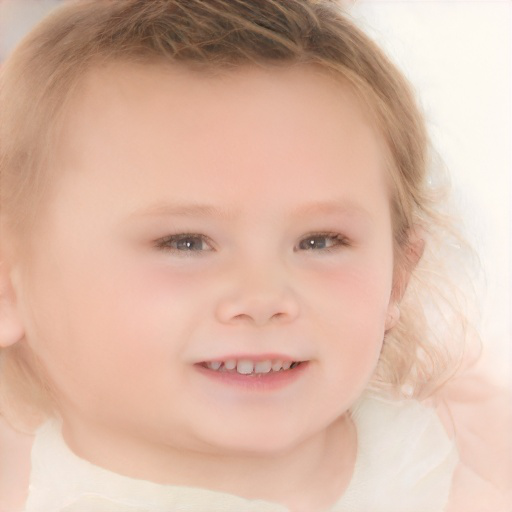

In [66]:
sample_image